In [10]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction,feature_selection, model_selection, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, recall_score,precision_score, confusion_matrix

In [11]:
# read data
emails= pd.read_csv('prepared.csv')

In [12]:
emails= emails[emails['category'] != "autre"]

In [13]:
# split dataset
emails_train, emails_test = model_selection.train_test_split(emails, test_size=0.3, random_state=3)
y_train = emails_train["category"].values
y_test = emails_test["category"].values
X_train= emails_train["text"].values
X_test = emails_test["text"].values

In [14]:
## Tf-Idf vectorisation
vectorizer = feature_extraction.text.TfidfVectorizer()

In [15]:
# creating the pipeline for traing the model (XGBoost)
classifier = KNeighborsClassifier()
model = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("dim_reduction", TruncatedSVD(n_components= 270 )),
                           ("classifier", classifier)])

In [16]:
## params
params = {
    'classifier__n_neighbors': (2, 3, 4, 5, 6, 7, 8),
    'classifier__metric': ('minkowski', 'euclidean', 'manhattan')
}
##accuracy
grid_search_acc = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5)
grid_search_acc = grid_search_acc.fit(X_train, y_train)

In [17]:
## evaluating the model
print('best parameters: ', grid_search_acc.best_params_)

best parameters:  {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 3}


In [19]:
## Recall
rec_avg=make_scorer(recall_score, average='macro')
grid_search_rec= GridSearchCV(estimator=model, param_grid= params, scoring=rec_avg,cv=5, n_jobs=-1)
grid_search_rec= grid_search_rec.fit(X_train, y_train)

In [20]:
## evaluating the model
print('best parameters: ', grid_search_rec.best_params_)

best parameters:  {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 3}


In [21]:
## precision
prec_avg=make_scorer(precision_score, average='macro')
grid_search_prec_avg= GridSearchCV(estimator=model, param_grid= params, scoring=prec_avg,cv=5, n_jobs=-1)
grid_search_prec_avg= grid_search_prec_avg.fit(X_train, y_train)

In [22]:
## evaluating the model
print('best parameters: ', grid_search_prec_avg.best_params_)

best parameters:  {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 3}


In [36]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, titre):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.set_ylim([0.2,0.9])
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title(titre, fontsize=18, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=14)
    ax.set_ylabel(titre+'[CV Avg Score]', fontsize=14)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

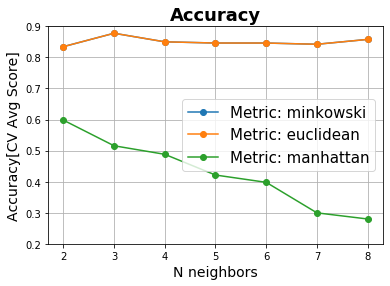

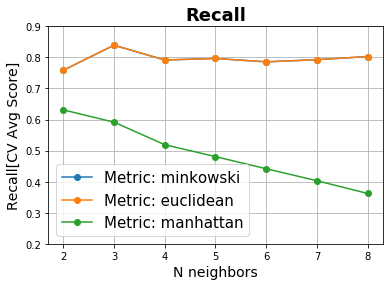

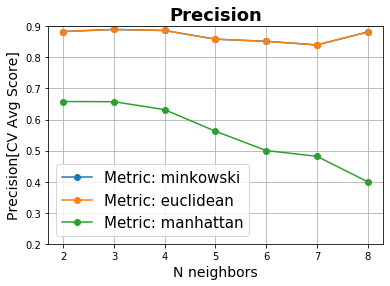

In [37]:
# Calling Method 
plot_grid_search(grid_search_acc.cv_results_, params['classifier__n_neighbors'], params['classifier__metric'], 'N neighbors', 'Metric', 'Accuracy')
plot_grid_search(grid_search_rec.cv_results_, params['classifier__n_neighbors'], params['classifier__metric'], 'N neighbors', 'Metric', 'Recall')
plot_grid_search(grid_search_prec_avg.cv_results_, params['classifier__n_neighbors'], params['classifier__metric'], 'N neighbors', 'Metric', 'Precision')

In [28]:
## return index for dataframe
def return_index_list(param1, param2):
    list=[]
    for p1 in param1:
        for p2 in param2:
            list.append('['+str(p1)+', '+str(p2)+']')
    return list
index= return_index_list(params['classifier__metric'], params['classifier__n_neighbors'])

In [30]:
df= pd.DataFrame({  'Accuracy': grid_search_acc.cv_results_['mean_test_score'],
                    'Precision(Avg)': grid_search_prec_avg.cv_results_['mean_test_score'],
                    'Recall(Avg)': grid_search_rec.cv_results_['mean_test_score'],
                     'std_cross_validation': grid_search_acc.cv_results_['std_test_score']},
                 index=index)
## to excel
writer = pd.ExcelWriter('KNN.xlsx')
df.to_excel(writer, 'KNN')
writer.save()
writer.close()

In [32]:
df

,Accuracy,Precision(Avg),Recall(Avg),std_cross_validation
"[minkowski, 2]",0.834588,0.883439,0.758671,0.034458
"[minkowski, 3]",0.877804,0.890035,0.839356,0.036574
"[minkowski, 4]",0.850196,0.886698,0.791727,0.041309
"[minkowski, 5]",0.846353,0.858678,0.796682,0.042289
"[minkowski, 6]",0.846275,0.851965,0.785767,0.042700
"[minkowski, 7]",0.842353,0.840157,0.792689,0.038053
"[minkowski, 8]",0.858039,0.881883,0.802838,0.039169
"[euclidean, 2]",0.834588,0.883439,0.758671,0.034458
"[euclidean, 3]",0.877804,0.890035,0.839356,0.036574
"[euclidean, 4]",0.850196,0.886698,0.791727,0.041309


Accuracy: 0.9
Detail:
              precision    recall  f1-score   support

   formation       0.90      0.95      0.92        63
   scolarité       0.90      0.72      0.80        25
       sport       0.93      1.00      0.97        14
   événement       0.86      0.86      0.86         7

    accuracy                           0.90       109
   macro avg       0.90      0.88      0.89       109
weighted avg       0.90      0.90      0.90       109



(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'formation'),
  Text(0, 1.5, 'scolarité'),
  Text(0, 2.5, 'sport'),
  Text(0, 3.5, 'événement')])

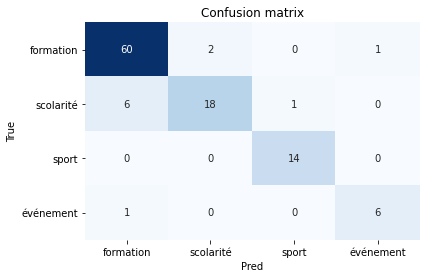

In [13]:
#evaluation
predicted = grid_search_acc.best_estimator_.predict(X_test)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)